In [2]:
import numpy as np
import math
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd

In [17]:
# Note for jupyter notebook
# use this for reload in jupyter notebook
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,fe,statistic

In [35]:
%reload_ext autoreload

In [3]:
# Probability of digit (d) occurring in nth position
def calc_expected_probability(d: int, n: int) -> float:
    # generalization of Benford's Law ~ Summation( log[ 1 + (1/(10k+d)] ) where d = digit, k = (10^(n-2), 10^(n-1))
    # source: https://en.wikipedia.org/wiki/Benford%27s_law
    prob = 0
    if (d == 0) and (n == 1):
        prob = 0
    elif n == 1:
        prob = math.log10(1 + (1 / d))
    else:
        l_bound = 10 ** (n - 2)
        u_bound = 10 ** (n - 1)
        for k in range(l_bound, u_bound):
            prob += math.log10(1 + (1 / (10 * k + d)))
    return round(prob, 3)

In [4]:
# populate matrix with Benford's Law (10x10 matrix for r= digit, c=location - 1)
expected_prob_matrix = np.zeros((10, 2))
for d_i in range(expected_prob_matrix.shape[0]):
    for n_i in range(expected_prob_matrix.shape[1]):
        expected_prob_matrix[d_i, n_i] = calc_expected_probability(d_i, n_i + 1)

In [44]:
# Import data and extract digits
data = pd.read_csv('transactions_real.csv', header=None)
data.columns = ['original']
data['cleaned'] = data.original.str.replace("-", "")
data['cleaned'] = data.cleaned.str.replace(",", "")
data['first_digit'] = data.cleaned.str[0].astype(int)
data['second_digit'] = data.cleaned.str.replace(",", "").str[1]
data['second_digit'] = data['second_digit'].apply(lambda x: int(x) if x.isdigit() else 'NaN')

In [45]:
data

,original,cleaned,first_digit,second_digit
0,"36,233.22",36233.22,3,6
1,"66,627.98",66627.98,6,6
2,"10,781.82",10781.82,1,0
3,"13,570.08",13570.08,1,3
4,"6,337.82",6337.82,6,3
...,...,...,...,...
2124,"14,973.35",14973.35,1,4
2125,"8,978.05",8978.05,8,9
2126,"2,080.14",2080.14,2,0
2127,"6,552.00",6552.00,6,5


In [7]:
# Compute observed probability matrix
observed_prob_matrix = np.zeros((10, 2))
data_cols_length = [data.first_digit.count(), data[data.second_digit != 'NaN'].second_digit.count()]

for d_i in range(observed_prob_matrix.shape[0]):
    for n_i in range(observed_prob_matrix.shape[1]):
        observed_prob_matrix[d_i, n_i] = data[data.iloc[:, n_i + 2] == d_i].iloc[:, n_i + 2].count() / \
                                         data_cols_length[n_i]

# store Confidence Intervals
u_bound_matrix = np.zeros((10, 2))
l_bound_matrix = np.zeros((10, 2))
h_length_matrix = np.zeros((10, 2))

In [8]:
# Calculate Confidence Intervals for probability matrix
def calc_confidence_interval(alpha):
    alpha_stat = stats.norm.ppf(1 - (1 - alpha) / 2)

    for d_i in range(expected_prob_matrix.shape[0]):
        for n_i in range(expected_prob_matrix.shape[1]):
            prop_exp = expected_prob_matrix[d_i, n_i]
            half_length = alpha_stat * (prop_exp * (1 - prop_exp) / data_cols_length[n_i]) ** .5 + (
                        1 / (2 * data_cols_length[n_i]))
            u_bound = prop_exp + half_length
            l_bound = prop_exp - half_length
            h_length_matrix[d_i, n_i] = half_length
            u_bound_matrix[d_i, n_i] = u_bound
            l_bound_matrix[d_i, n_i] = max(l_bound, 0)

In [10]:
alpha_level = .999
calc_confidence_interval(alpha_level)

In [11]:
# Locate rules that have been violated, save them to a list
list_of_rules_violated = []

In [12]:
for d_i in range(observed_prob_matrix.shape[0]):
    for n_i in range(observed_prob_matrix.shape[1]):
        obs = observed_prob_matrix[d_i, n_i]
        u_bound = u_bound_matrix[d_i, n_i]
        l_bound = l_bound_matrix[d_i, n_i]
        # if observation outside of bounds (violates Benford's Law) store as tuple (digit, place)
        if (obs > u_bound) or (obs < l_bound):
            print("Violation: Digit {} in {} place".format(d_i, n_i + 1))
            list_of_rules_violated.append((d_i, n_i))

Violation: Digit 2 in 1 place
Violation: Digit 5 in 1 place
Violation: Digit 5 in 2 place
Violation: Digit 8 in 1 place


In [13]:
# locate specific transactions that violated, save their index to a list
data_that_violated = []

for (d_i, n_i) in list_of_rules_violated:
    rule_violated_data = data[data.iloc[:, n_i + 2] == d_i]['original'].index.to_list()
    for number in rule_violated_data:
        data_that_violated.append(number)

violations_df = data.iloc[data_that_violated, [0, 2, 3]].drop_duplicates('original')
print("Total violations: {}".format(violations_df['original'].count()))

Total violations: 599


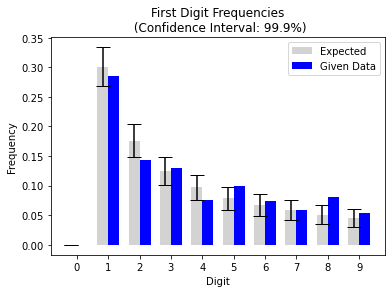

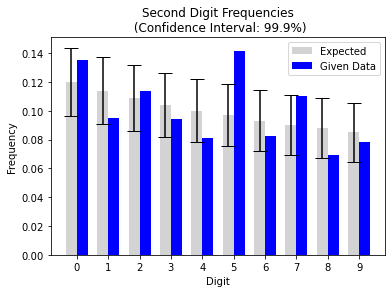

In [15]:
# plot charts and confidence intervals
def plot_charts(digit_location):
    # set X-axis
    x = np.arange(10)
    width = .35
    fig, ax = plt.subplots()

    # create series
    ax.bar(x - width / 2, expected_prob_matrix[:, digit_location], width,
           yerr=h_length_matrix[:, digit_location],
           capsize=7,
           label='Expected',
           color='#d3d3d3',
           figure=fig)
    ax.bar(x + width / 2, observed_prob_matrix[:, digit_location], width,
           label='Given Data',
           color='blue',
           figure=fig)
    ax.legend()
    ax.set_xticks(x)

    if digit_location == 0:
        title = 'First Digit Frequencies\n (Confidence Interval: {}%)'.format(alpha_level * 100)
    else:
        title = 'Second Digit Frequencies\n (Confidence Interval: {}%)'.format(alpha_level * 100)
    plt.title(title, figure=fig)

    plt.xlabel('Digit', figure=fig)
    plt.ylabel('Frequency', figure=fig)

    return fig

plt_0 = plot_charts(0)
plt_1 = plot_charts(1)
# plt_0.show()
# plt_1.show()

In [81]:
%reload_ext autoreload

In [82]:
# Import data and extract digits
data = pd.read_csv('transactions_real.csv', header=None)
data.columns = ['original']
data['cleaned'] = data.original.str.replace("-", "")
data['cleaned'] = data.cleaned.str.replace(",", "")

Violation: Digit 2 in 1 place
Violation: Digit 5 in 1 place
Violation: Digit 5 in 2 place
Violation: Digit 8 in 1 place
Total violations: 594


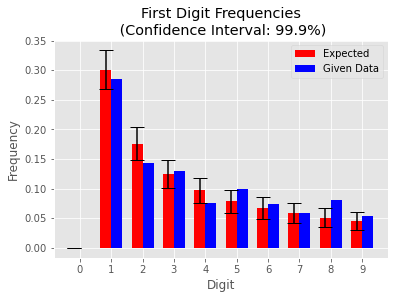

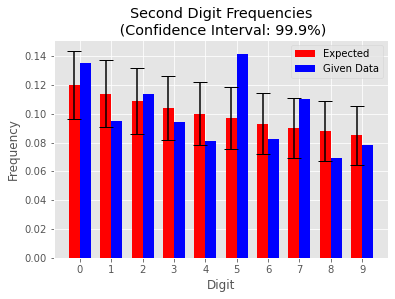

In [83]:
statistic.benford_law(data,'cleaned',10,2,.999)